Import Libraires

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Dataset Download and Unzip the dataset

In [ ]:
!gdown --id 1kOFloFsyuORUMeOszv5LEZvXhv1F4VII

Downloading...
From: https://drive.google.com/uc?id=1kOFloFsyuORUMeOszv5LEZvXhv1F4VII
To: /content/breastCWisconsin.rar
100% 2.05M/2.05M [00:00<00:00, 131MB/s]


In [ ]:
!mkdir inputs
!unrar x "/content/breastCWisconsin.rar" && rm -r "/content/breastCWisconsin.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/breastCWisconsin.rar

Creating    breastCWisconsin                                          OK
Creating    breastCWisconsin/2                                        OK
Extracting  breastCWisconsin/2/0.png                                       0%  OK 
Extracting  breastCWisconsin/2/1.png                                       0%  OK 
Extracting  breastCWisconsin/2/10.png                                      0%  OK 
Extracting  breastCWisconsin/2/102.png                                     0%  OK 
Extracting  breastCWisconsin/2/108.png                                     0%  OK 
Extracting  breastCWisconsin/2/11.png                                      0%  OK 
Extracting  breastCWisconsin/2/110.png                                     0%  OK 
Extracting  breastCWisconsin/2/114.png                                     1%  OK 
Ex

In [ ]:
!mv "/content/breastCWisconsin" "/content/inputs"

Split the dataset into train and val

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders  # or import split_folders
splitfolders.ratio("/content/inputs/breastCWisconsin", output="/content/inputs/output/", seed=1337, ratio=(.80,.2), group_prefix=None) # default values

Copying files: 699 files [00:00, 9674.12 files/s]


#Basics EDA

In [ ]:
total_folders = sorted(glob('//content/inputs/output/*/*/*'))
len(total_folders)

699

In [ ]:
train_folders = sorted(glob('//content/inputs/output/train/*/*'))
len(train_folders)

558

In [ ]:
val_folders = sorted(glob('//content/inputs/output/val/*/*'))
len(val_folders)

141

In [ ]:
test_folders = sorted(glob('//content/inputs/output/test/*/*'))
len(test_folders)

0

In [ ]:
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
    
    return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');


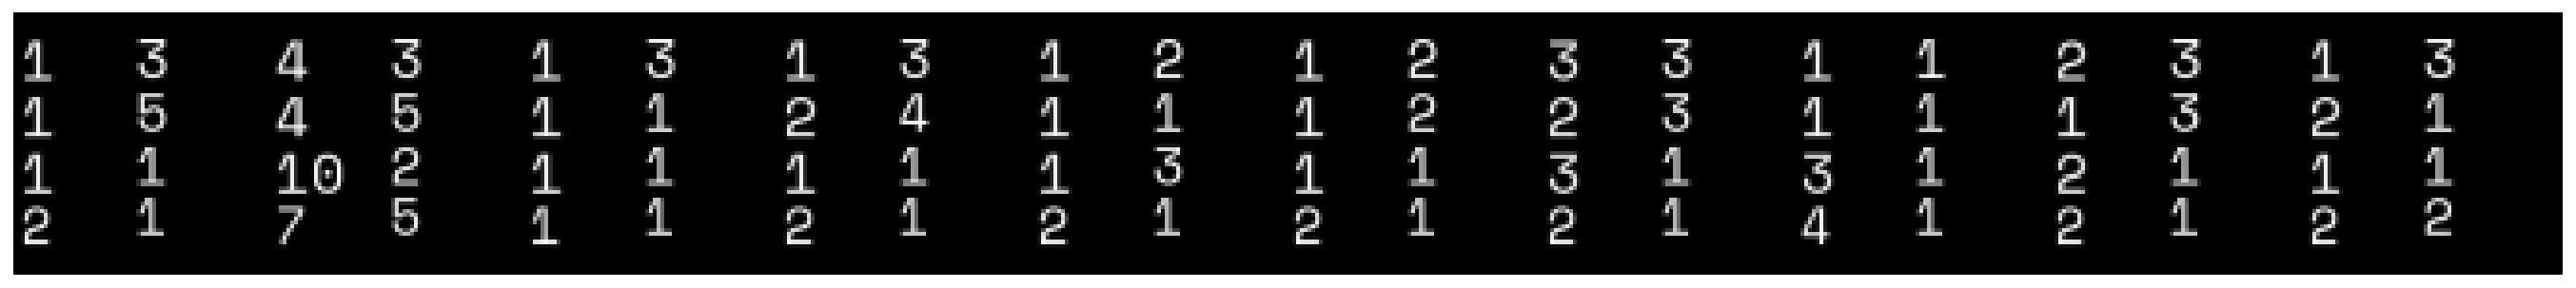

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}')) for tf in train_folders[:10]]
show_sign_grid(sample_images)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


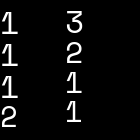

In [ ]:
from google.colab.patches import cv2_imshow
train_folders[16]
img = cv2.cvtColor(cv2.imread(train_folders[16]), cv2.COLOR_BGR2RGB)
print(img)
cv2_imshow(img)

In [ ]:
#img_path = glob(f'{train_folders[16]}')
#show_image(img_path)

Creating Data folder corresponding their train and validation.

In [ ]:
class_names = ["2", "4"]
class_indices = [0, 1]
DATA_DIR = Path("/content/inputs/output")
DATASETS = ['train', 'val']

# for ds in DATASETS:
#     for cls in class_names:
#         (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
# train_folders = "/content/inputs/output/train"
# for i, cls_index in enumerate(class_indices):
#   image_paths = np.array(glob(f'{train_folders}/{[cls_index]}/*.png'))
#   class_name = class_names[i]
#   print(f'{class_name}: {len(image_paths)}')
#   np.random.shuffle(image_paths)
#   ds_split = np.split(
#     image_paths,
#     indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
#   )
#   dataset_data = zip(DATASETS, ds_split)
#   for ds, images in dataset_data:
#     for img_path in images:
#       #shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

In [ ]:
# !rm -r "/content/inputs/output/train/Yes"
# !rm -r "/content/inputs/output/train/No"
# !rm -r "/content/inputs/output/val/No"
# !rm -r "/content/inputs/output/val/Yes"

Augmentation on Images

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
transforms = {'train': T.Compose([
  #T.RandomResizedCrop(size=128),
  #T.RandomRotation(degrees=15),
  #T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  #T.Resize(size=128),
  #T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
 ])


}

Dataset Load into a DataLoader

In [ ]:
DATA_DIR, DATASETS

(PosixPath('/content/inputs/output'), ['train', 'val'])

In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}
data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=2)
  for d in DATASETS
}

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 558, 'val': 141}

In [ ]:
class_names = image_datasets['train'].classes
class_names

['2', '4']

In [ ]:
# !rm -r "/content/inputs/output/.ipynb_checkpoints"

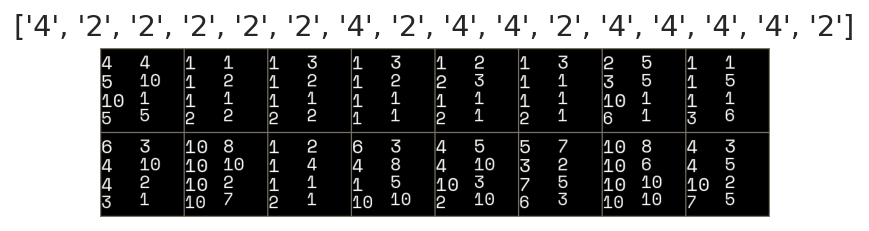

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Using a pretrained model
* as we are using `resnet18` model from `torchvision.model`

In [ ]:
def create_model(n_classes):
  model = models.resnet18(pretrained=True)
  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)

In [ ]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Training Evaluation methods

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

Validation/Test sets Evaluations method

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

Our training method
* For `optimizer` : we used `SGD` optimizer
* For Loss Function : we use `CrossEntropyLoss` loss functions
* Learning rate : `0.001`
* Epoch : by default `3`
<br>
This method will return the `best trained model` and it's training `history`

In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=15):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8)
  # optimizer = optim.Adam(model.)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.05)
  loss_fn = nn.CrossEntropyLoss().to(device)
  history = defaultdict(list)
  best_accuracy = 0
  for epoch in range(n_epochs):
    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],
      loss_fn,
      optimizer,
      device,
      scheduler,
      dataset_sizes['train']
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.pth')
      best_accuracy = val_acc
  print(f'Best val accuracy: {best_accuracy}')
  model.load_state_dict(torch.load('best_model_state.pth'))
  return model, history

Our training method called

In [ ]:
%%time
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=15)

Epoch 1/15
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train loss 0.24061864225992136 accuracy 0.9050179211469535
Val   loss 0.0852217519034942 accuracy 0.9716312056737588

Epoch 2/15
----------
Train loss 0.09861844299095017 accuracy 0.956989247311828
Val   loss 0.07313165456677477 accuracy 0.9787234042553191

Epoch 3/15
----------
Train loss 0.05827731613868049 accuracy 0.9802867383512545
Val   loss 0.06965903228976661 accuracy 0.9787234042553191

Epoch 4/15
----------
Train loss 0.04591565861233643 accuracy 0.9910394265232975
Val   loss 0.06522416695952415 accuracy 0.9716312056737588

Epoch 5/15
----------
Train loss 0.041691744886338714 accuracy 0.985663082437276
Val   loss 0.07198218354541394 accuracy 0.9716312056737588

Epoch 6/15
----------
Train loss 0.031306405777909926 accuracy 0.9946236559139785
Val   loss 0.06475081682826082 accuracy 0.9716312056737588

Epoch 7/15
----------
Train loss 0.02392705091541367 accuracy 0.996415770609319
Val   loss 0.06732844281941652 accuracy 0.9716312056737588

Epoch 8/15
----------
Train loss 0.02

In [ ]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  fig.suptitle('Training history')


plot_training_history(history)

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')
        if images_handeled == n_images:
          return

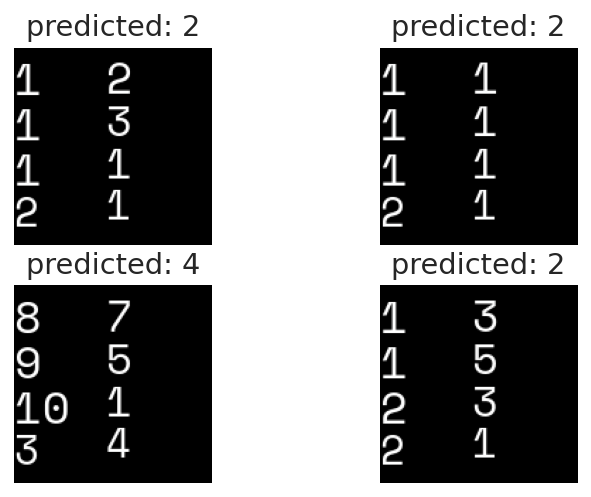

In [ ]:
show_predictions(base_model, class_names, n_images=4)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
class_names

['2', '4']

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['val'])
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           2       0.99      0.98      0.98        92
           4       0.96      0.98      0.97        49

    accuracy                           0.98       141
   macro avg       0.97      0.98      0.98       141
weighted avg       0.98      0.98      0.98       141



In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):
  cm = confusion_matrix.copy()
  cell_counts = cm.flatten()
  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])
  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Actual')
  plt.xlabel('Predicted');

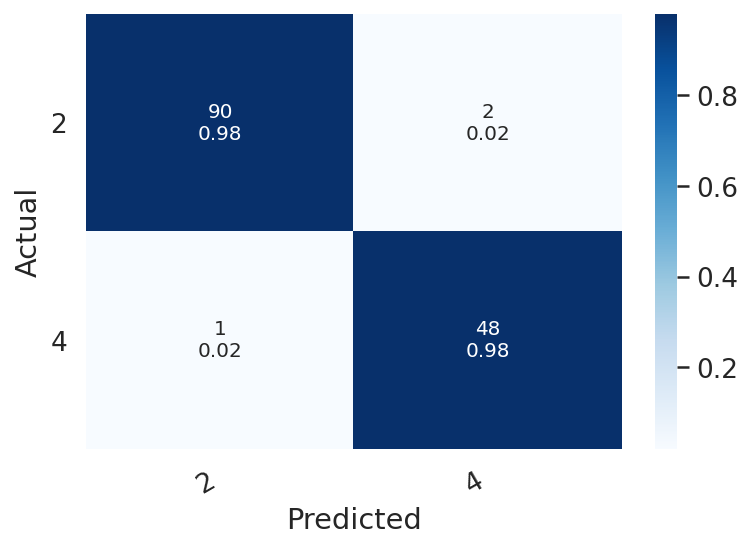

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

Roc & Auc

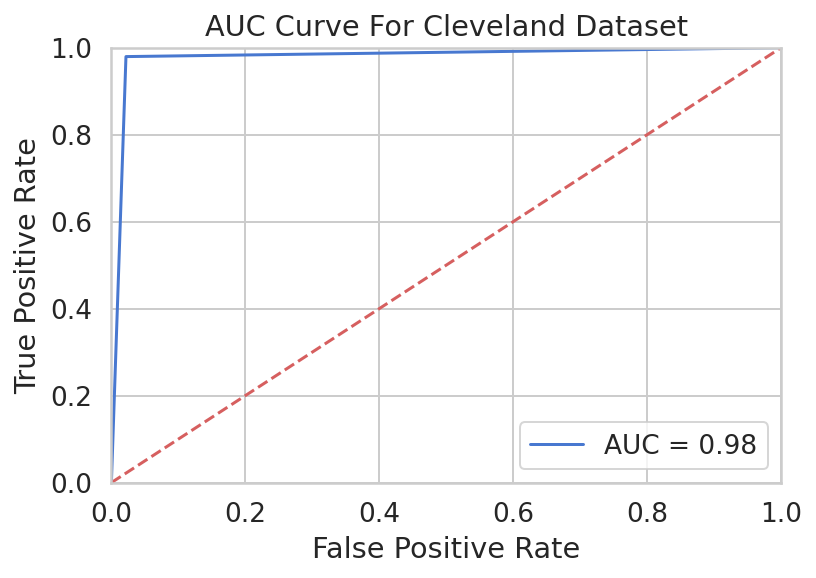

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
fpr, tpr, thresholds
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('AUC Curve For Cleveland Dataset')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['val'](img).unsqueeze(0)
  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

In [ ]:
pred = predict_proba(base_model, '/content/inputs/breastCWisconsin/4/111.png')
pred

array([0.08507796, 0.914922  ], dtype=float32)

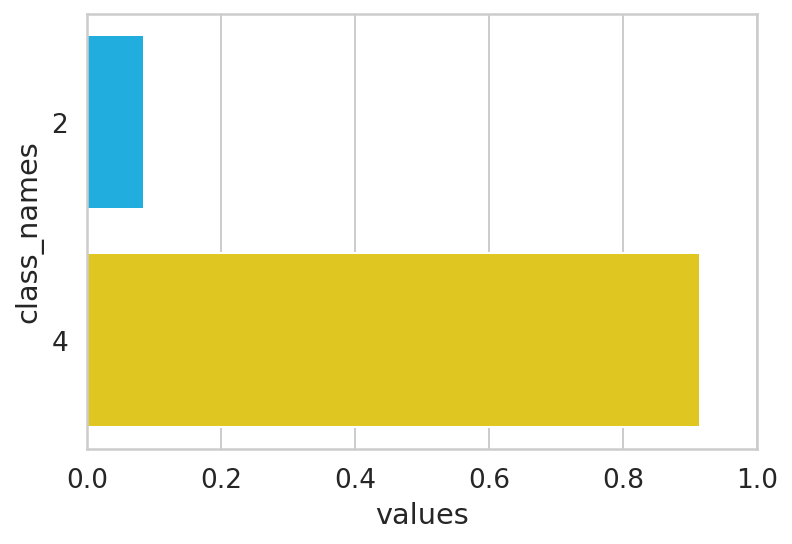

In [ ]:
show_prediction_confidence(pred, class_names)

## DenseNet

In [ ]:
def create_dense_model(n_classes):
  model = models.densenet121(pretrained=True)
  n_features = model.classifier.in_features
  model.fc = nn.Linear(n_features, n_classes)
  return model.to(device)


dense_model = create_dense_model(len(class_names))

In [ ]:
%%time
dense_model, history = train_model(dense_model, data_loaders, dataset_sizes, device, n_epochs=15)

Epoch 1/15
----------
Train loss 1.5833502692702626 accuracy 0.7992831541218638
Val   loss 0.2933264950083362 accuracy 0.9361702127659575

Epoch 2/15
----------
Train loss 0.12901600185515624 accuracy 0.967741935483871
Val   loss 0.08136246612088548 accuracy 0.9645390070921985

Epoch 3/15
----------
Train loss 0.07557945031938808 accuracy 0.978494623655914
Val   loss 0.06607495517366463 accuracy 0.9716312056737588

Epoch 4/15
----------
Train loss 0.04639208167126136 accuracy 0.9838709677419355
Val   loss 0.06566606214942618 accuracy 0.9787234042553191

Epoch 5/15
----------
Train loss 0.025809630884655883 accuracy 0.9946236559139785
Val   loss 0.08903938606898817 accuracy 0.9787234042553191

Epoch 6/15
----------
Train loss 0.00855785490213228 accuracy 0.9982078853046595
Val   loss 0.0765997632406652 accuracy 0.9787234042553191

Epoch 7/15
----------
Train loss 0.014037154026196472 accuracy 0.992831541218638
Val   loss 0.08052226593200532 accuracy 0.9787234042553191

Epoch 8/15
------

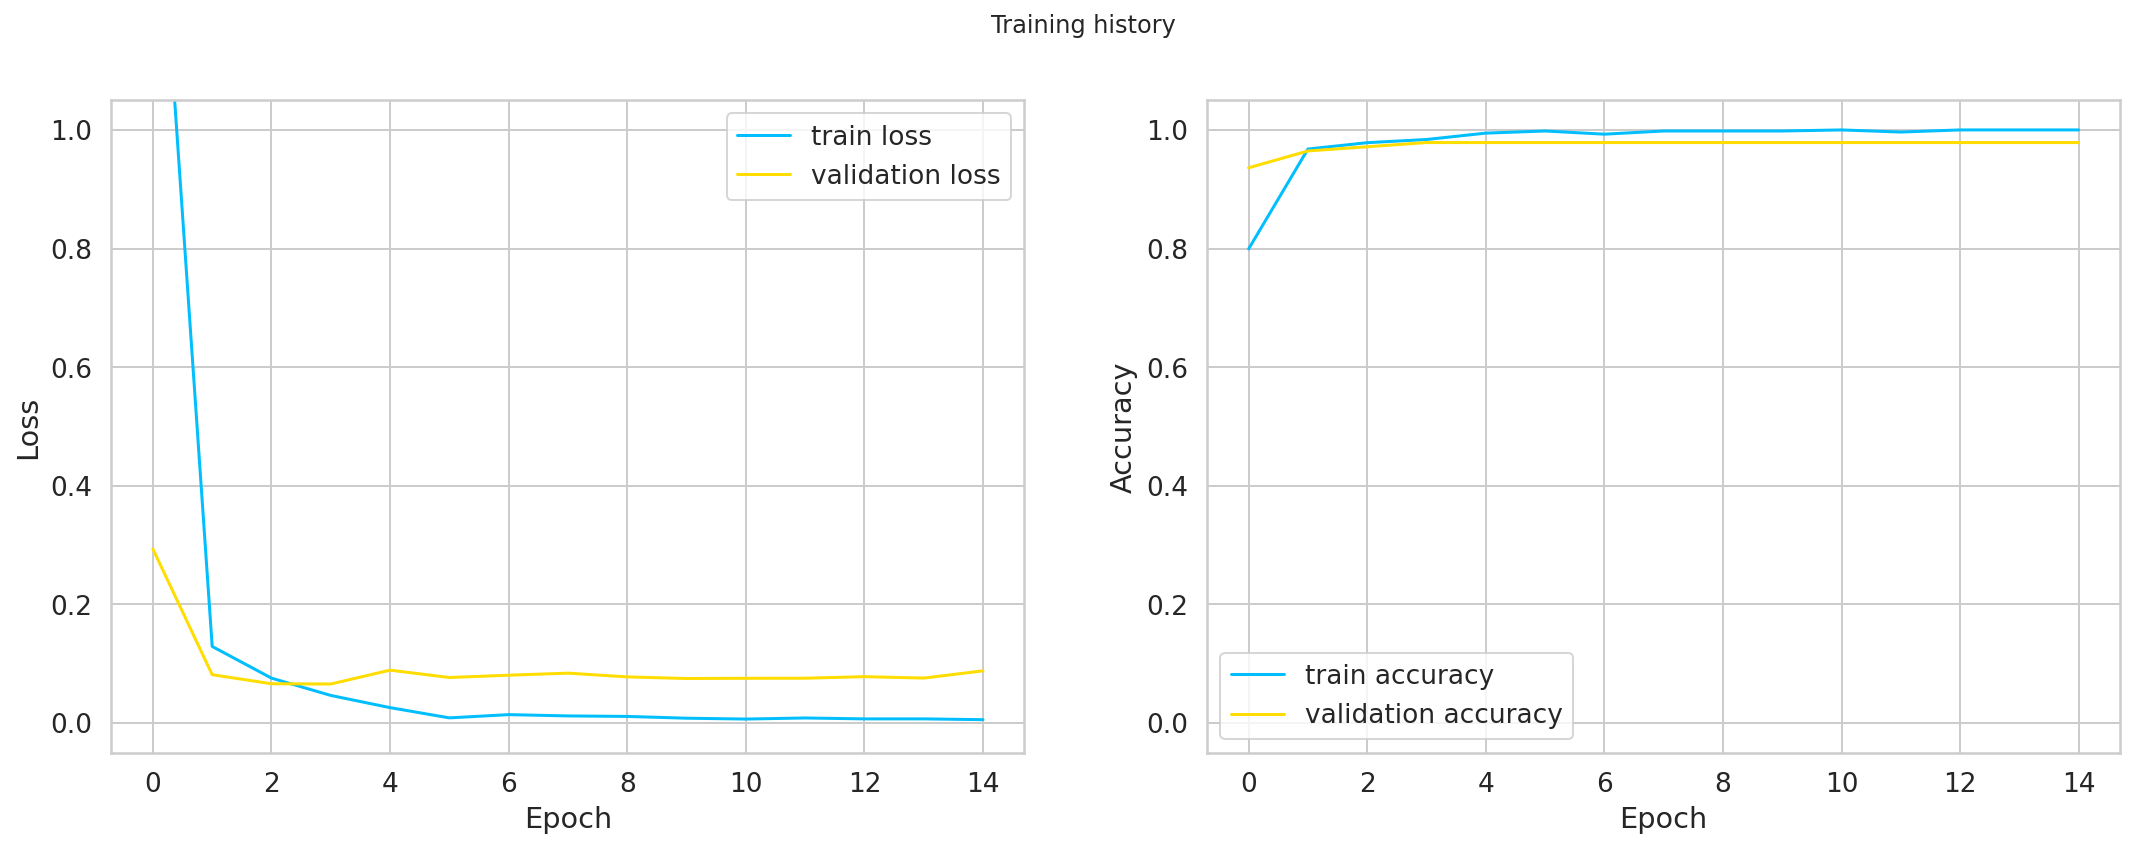

In [ ]:
plot_training_history(history)

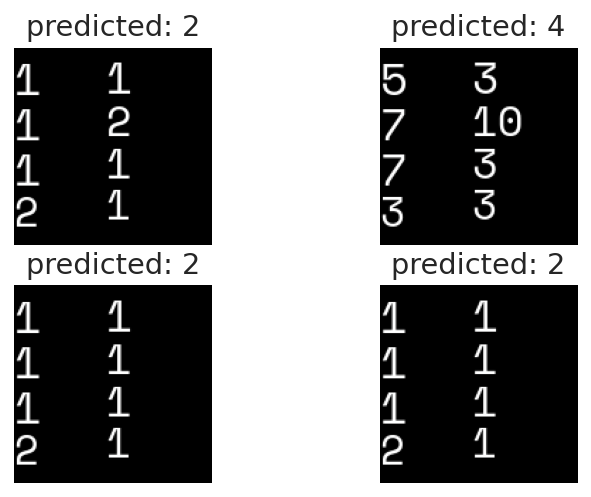

In [ ]:
show_predictions(dense_model, class_names, n_images=4)

In [ ]:
y_pred, y_test = get_predictions(dense_model, data_loaders['val'])
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           2       0.99      0.98      0.98        92
           4       0.96      0.98      0.97        49

    accuracy                           0.98       141
   macro avg       0.97      0.98      0.98       141
weighted avg       0.98      0.98      0.98       141



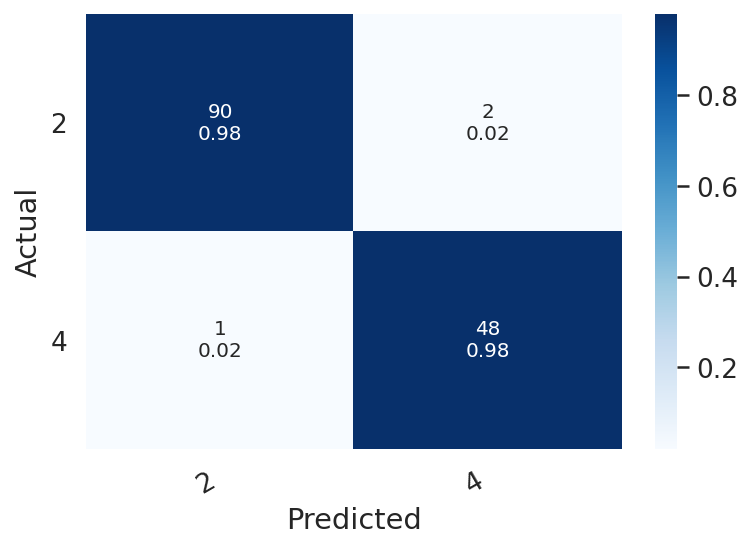

In [ ]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

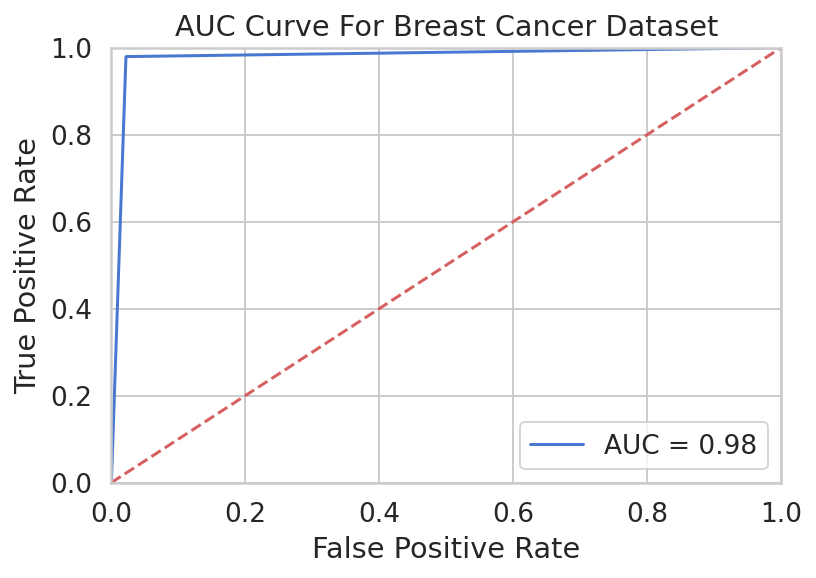

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
fpr, tpr, thresholds
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('AUC Curve For Breast Cancer Dataset')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Google LeNet

In [ ]:
m = models.googlenet(pretrained=True)
m

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
def create_lenet_mode(n_classes):
    model = models.googlenet(pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)
    return model.to(device)


googlenet_base_model = create_lenet_mode(len(class_names))

In [ ]:
%%time
googlenet_model, history = train_model(googlenet_base_model, data_loaders, dataset_sizes, device, n_epochs=15)

Epoch 1/15
----------
Train loss 0.36189840521131245 accuracy 0.8530465949820788
Val   loss 0.31913206312391496 accuracy 0.9645390070921985

Epoch 2/15
----------
Train loss 0.1692632227071694 accuracy 0.946236559139785
Val   loss 0.14043108663625187 accuracy 0.9787234042553191

Epoch 3/15
----------
Train loss 0.13900674059987067 accuracy 0.956989247311828
Val   loss 0.08969970668355624 accuracy 0.9716312056737588

Epoch 4/15
----------
Train loss 0.1232650692973818 accuracy 0.9713261648745519
Val   loss 0.08378288191225794 accuracy 0.9787234042553191

Epoch 5/15
----------
Train loss 0.09278327524662018 accuracy 0.9731182795698925
Val   loss 0.08394780175553428 accuracy 0.9787234042553191

Epoch 6/15
----------
Train loss 0.07968265078961849 accuracy 0.9767025089605734
Val   loss 0.06784521581398116 accuracy 0.9787234042553191

Epoch 7/15
----------
Train loss 0.06828204824456147 accuracy 0.9874551971326165
Val   loss 0.0667929229223066 accuracy 0.9787234042553191

Epoch 8/15
-------

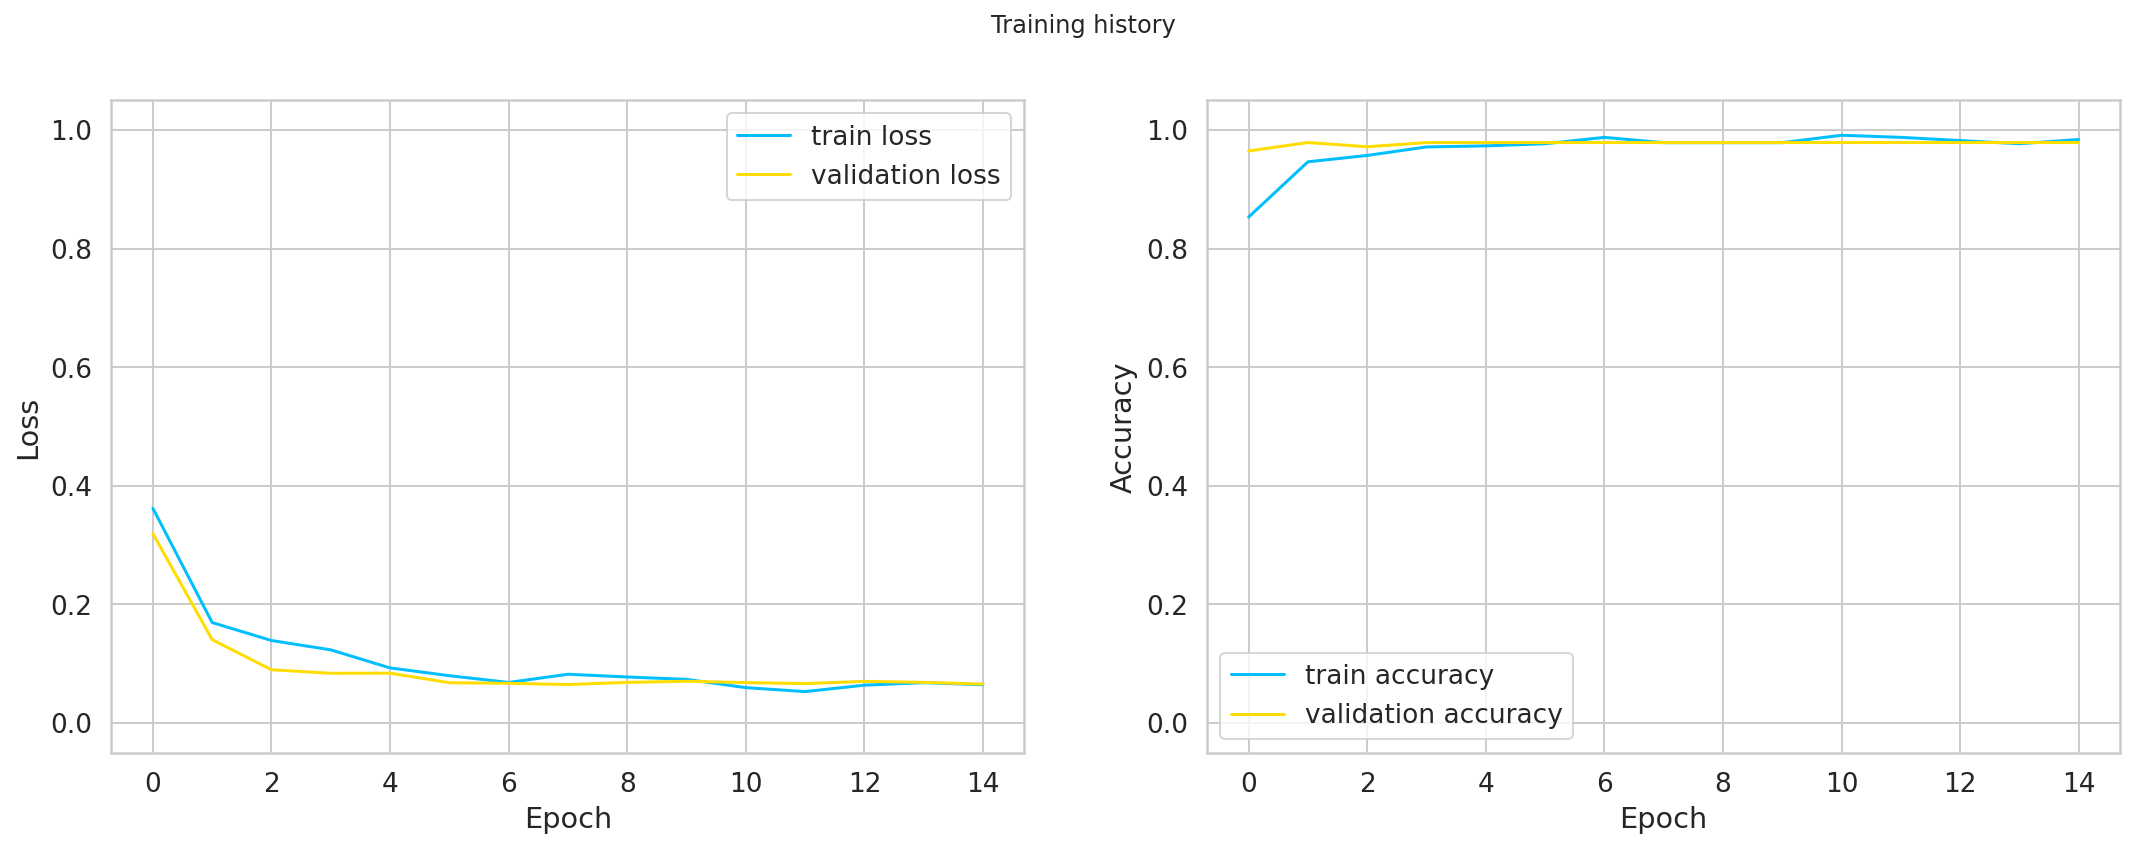

In [ ]:
plot_training_history(history)

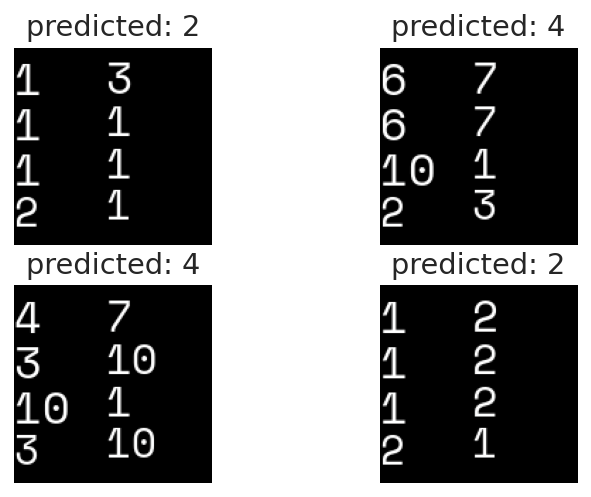

In [ ]:
show_predictions(googlenet_model, class_names, n_images=4)

              precision    recall  f1-score   support

           2       1.00      0.97      0.98        92
           4       0.94      1.00      0.97        49

    accuracy                           0.98       141
   macro avg       0.97      0.98      0.98       141
weighted avg       0.98      0.98      0.98       141



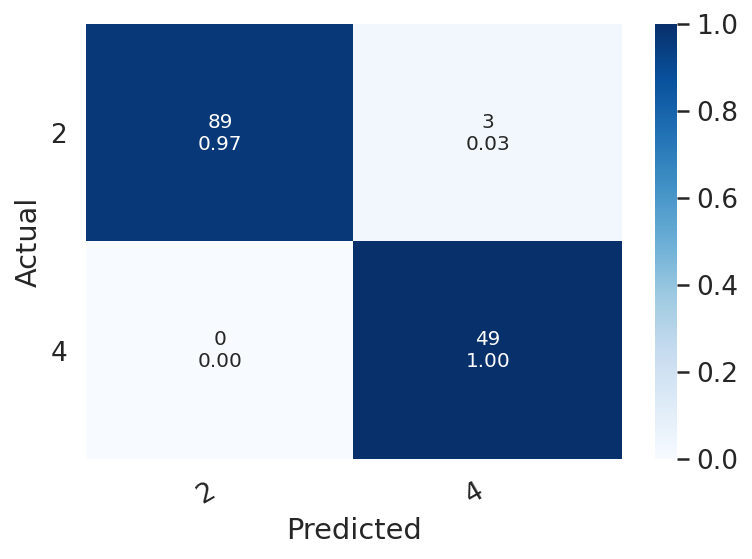

In [ ]:
y_pred, y_test = get_predictions(googlenet_model, data_loaders['val'])
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

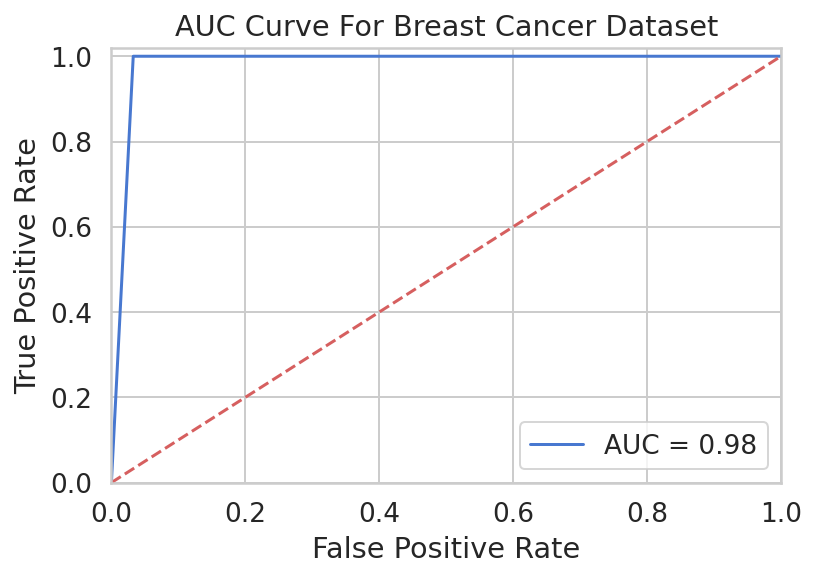

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
fpr, tpr, thresholds
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('AUC Curve For Breast Cancer Dataset')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## With Custom Model
For Designing a custom CNN model, it is important to careful with `image dimension` , `input size`, `filter number` , `stride`, `pooling`,  and `output shape`

`Image Dimension`
CNN 2D can be apply in 2 dimensional grayscale or color images, Normally 2D images contains image width, height, color channel. <br>
Grayscale images contains (1, width, height) 1 color channel for different shades of Gray. <br>
Normall, images contains the RGB color (Red, Green, Blue) & their structure looks like (RGB, width, height). Although they contains the 3 color channel but they called 2D images. Because when they represent to people then only 2 spatial information are shown explictly. <br>

---

`Filter`: A 2D CNN has 3D fileter which are shown in this link [lAnimated link](https://i.stack.imgur.com/FjvuN.gif). If the CNN takes grayscale images then the filter/channel of input layer of CNN is 1 & if the images was color/RGB images then the filter of input layer of CNN will be 3. 



---

In PyTorch:
For grayscale images the structure will be `[batch_size, 1, image_width, image_height]`
<br>
For Color/RGB images the structure will be `[batch_size, 3, image_width, image_height]`




In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
def feature_extractor():
    print("Feature Extractor")
    return nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=16,kernel_size =(3,3), stride=(1,1), padding=0),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(in_channels=16, out_channels=32,kernel_size =(3,3), stride=(1,1), padding=0),
    nn.MaxPool2d((2,2)),
    nn.Conv2d(in_channels=32, out_channels=64,kernel_size =(3,3), stride=(1,1), padding=0),
    
    )
    return

def classifier(n_classes):
    return nn.Linear(in_features=2048 , out_features=n_classes)

class CustomCNN(nn.Module):
    def __init__(self,n_classes=2):
        super(CustomCNN, self).__init__()
        self.features = feature_extractor()
        self.classifier = classifier(n_classes)
        
    def forward(self, x):
        x = self.feature(x)
        x = self.classifier(x)
        return x


#
custom_model = CustomCNN()
print(custom_model)


Feature Extractor
CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  )
  (classifier): Linear(in_features=2048, out_features=2, bias=True)
)


In [ ]:
import math

def conv_output(i,k=3,p=0,s=1):
 return ((i-k+(2*p))/s)+1


x1 = math.floor(conv_output(255))
print(x1)
x2 = math.floor(conv_output(x1, s=2))
print(x2)
x3 = math.floor(conv_output(x2))
print(x3)
x4 = conv_output(x3, s=2)
print(x4)
x5 = conv_output(x4, s=1)
print(x5)

253
126
124
61
59


253.0